In [2]:
import glob
import os, sys

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import multitest

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [3]:
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    MPRA = os.path.join(PATH, "delta_rank.csv")
    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    RE=os.path.join(PATH, "preprocessing")
    config, cfn = crw.read(os.path.join(os.getcwd(), "config.neuron.mpra.ini"))
else:
    
    PATH="/wynton/group/ahituv/fongsl/projects/biomarin/data"
    RE = "/wynton/group/ahituv/fongsl/projects/biomarin/results/eda"
    FASTA = os.path.join(PATH, "biomarin-lib2-hg38-final.fa")
    config, cfn = crw.read(os.path.join(os.getcwd(), "config.neuron.mpra.orig.ini"))
    
META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")
TILE_BED = os.path.join(PATH, "lib2.processed.bed")
ENH_BED = os.path.join(PATH, 'lib2.processed.merged.bed')
GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
DELTA_ACTIVITY= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
DELTA_ACTIVITY_Z= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
SIG_ACTIVITY_Z= os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")


section = 'lib2'
GABAS = glob.glob(config[section]["gaba"])
GLUTS = glob.glob(config[section]["glut"])
META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")

In [4]:
%%bash
ls /wynton/group/ahituv/fongsl/projects/biomarin/library_2/

design
result


In [5]:
GLUTS

['/wynton/group/ahituv/fongsl/projects/biomarin/library_2/result/merge_glut_1-byInsert.tsv',
 '/wynton/group/ahituv/fongsl/projects/biomarin/library_2/result/merge_glut_3-byInsert.tsv',
 '/wynton/group/ahituv/fongsl/projects/biomarin/library_2/result/merge_glut_2-byInsert.tsv']

## params 

In [6]:
RUNS = {"glut": GLUTS, 
       "gaba": GABAS}
MIN_TAGS = 10

DIFF_ZSCORE = True
if DIFF_ZSCORE is True:
    delta_file = DELTA_ACTIVITY_Z
    dif_col = "mean_z-score"
else:
    delta_file = DELTA_ACTIVITY
    dif_col="mean_log2ratio_centered"

# functions

In [7]:
def listToDf(file_list, section):
    """
    return concatenated dataframe of files from file_list

    input
        file_list (list) - list of file names as strings
        section (str) - variable should equal the string "lib2" or "lib1"

    method
        1. dictionary to collect dataframes
        2. iterate through files
        3. sample id str operations
        4. open file as pd dataframe
        5. formatting columns
            5.1.sample_id
            5.2.merge metadata
            5.3.log2 activity
        6. add df to dictionary
    return
        df of concatenated dictionary values
    """

    # 1
    dfs = {}

    # 2
    for f in file_list:

        # 3
        sample_id = (os.path.split(f)[1]).strip(
            "-byInsert.tsv")  # get sample id label

        # 4
        df = pd.read_csv(f, sep='\t')  # open dataframe

        # 5 formatting columns

        # 5.1
        # lib2 and lib1 have different file naming strategies

        if "merge" in f:  # lib1
            sample_id = sample_id.strip("merge")
            df["sample_id"] = "_".join(
                sample_id.split("_")[1:])  # add sample id
            df["celltype"] = sample_id.split("_")[1]
        else:
            df["sample_id"] = sample_id
            df["celltype"] = sample_id.split("_")[0]

        meta = pd.read_csv(META_DATA, sep='\t')
        df = pd.merge(df, meta, how="left")

        # 5.4
        df["log2ratio"] = np.log2(df["ratio"])
        # 6
        dfs[sample_id] = df  # add to dictionary

    return pd.concat(dfs.values())

# remove barcodes


def removeTags(df, min_tags):
    """remove barcodes with too few reads"""

    clean = df.loc[df["tags"] >= min_tags].copy()

    print(df.shape, clean.shape,
          f"removed tags w/ <{min_tags} barcodes N=",
          df.shape[0]-clean.shape[0])
    return clean

# compute median activity per trial


def ctrlMedians(df, activity_col):
    """summary stats for mpra activity, number of tags,
        and medians per replicate, 
        stratifying by shuffle/non-shuffle label"""

    # MPRA summary stats per replicate
    describe_activity = df.groupby(["ctrl", "sample_id"])[
        activity_col].describe().reset_index()

    # tag summary states per replicate
    describe_tags = df.groupby(["ctrl", "sample_id"])[
        "tags"].describe().reset_index()

    # MPRA median activity per replicate
    medians = df.groupby(["ctrl", "sample_id"])[
        activity_col].median().reset_index()

    return describe_activity, describe_tags, medians

# center activity of shuffled median per trial


def centerOnShufMed(df, mediandf):
    """center activity on shuffled median"""

    # get median of shuffles per trial
    shuf_med = mediandf.loc[mediandf["ctrl"].str.contains(
        "shuf"), ["sample_id", "log2ratio"]].copy()

    # rename median shuf col
    shuf_med = shuf_med.rename(columns={"log2ratio": "log2ratio_shufmedian"})

    # merge df w/ shuf_med
    df = pd.merge(df, shuf_med, how="left")

    # compute centered log2 ratio per median shuffle in trial
    df["log2ratio_centered"] = df["log2ratio"] - df["log2ratio_shufmedian"]

    # compute the zscore
    # df["z-score"] = stats.zscore(df["log2ratio"])
    df["z-score"] = stats.zscore(df["log2ratio_centered"])

    # get cell type
    cl = df["celltype"].iloc[0]

    # plot
    fig, ax = plt.subplots()
    sns.kdeplot(x="log2ratio", data=df, hue='sample_id',
                ls="dotted", label="input", common_norm=False)
    sns.kdeplot(x="log2ratio_centered", data=df,  hue='sample_id',
                label="Median shuffle-centered", common_norm=False)
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set(title=f"centering on shuffle median-{cl}")
    plt.savefig(os.path.join(
        RE, f"Median.shuf.centering.{cl}.pdf"), bbox_inches="tight")
    plt.show()

    return df

# compute mean activity across trials (after centering)
def meanRatio(df):
    vals = ["z-score",
          'log2ratio_centered']

    tables = {}
    for val in vals:
        print(val)
        # pivot data
        table = pd.pivot(df,
                         index="name",
                         columns="sample_id",
                         values=val).reset_index()

        # for calculating how many sequences are lost within a replicate
        before_triplicate = table.shape[0]
        table = table.dropna()

        # compute mean activity across the rows
        newcol = f'mean_{val}'
        table[newcol] = table[list(table)[-3:]].mean(axis=1)
        table = table.reset_index()

        # keep only sequences with three replicates -
        table_list = ["name", table.columns[-2],
                      table.columns[-3], table.columns[-4]]
        complete = set(table[table_list].dropna()["name"])

        table = table.loc[table["name"].isin(complete)]
        print("n sequences w/ <3 replicates removed, n=",
              before_triplicate-len(complete))
        tables[val] = table

    table = pd.merge(tables[vals[0]][["name", f"mean_{vals[0]}"]],
                     tables[vals[1]][["name", f"mean_{vals[1]}"]])

    table = pd.merge(
        df[["name", "coor", "strand", "ctrl", "celltype"]], table, how='right').drop_duplicates()

    return table


def computePval(df, constants_list):
    """ compute per sequence ttest of ctrl v. ultrasound rep
        assume equal_var is False, 
        FDR correction w alpha= 0.05
    """
    
    #melted = pd.melt(df, index="name", values = constants_list)
    df["pval"] = None

    for i, row in df.iterrows():

        # get control replicates
        ctrls = row[constants_list[:3]]

        # get US replicates
        uss = row[constants_list[3:]]

        # t-test per sequence, no equal variance assumed.
        t, p = stats.ttest_ind(list(ctrls), list(uss), equal_var=False)

        # update dataframe
        df.at[i, 'pval'] = p
        
    # repeated measures stat
    #for enh_id in set(df["enh.id"]):
    #    df.loc[]
    
    # fdr correction
    df["fdr_bool"], df["fdr"] = multitest.fdrcorrection(df["pval"], alpha=0.05)
    
    return df


# label active as > 95% of shuffle

def labelActive(df, act_col, celltype):
    """based on whether activity exceeds 95% of shuffled distribution elements
    note - this is a percentile interval, not a confidence interval
    """
    # act_col = 'mean_centered_log2ratio'
    # celltype="glut"

    # compute median of the positive control activity values (mean across centered activity scores)
    pos_thresh = df.loc[df["ctrl"] == "shuffle", act_col].quantile(0.975)
    neg_thresh = df.loc[df["ctrl"] == "shuffle", act_col].quantile(0.025)

    print(act_col, "shuf top 97.5% =",
          round(pos_thresh, 2), "shuf bottom 2.5% =",
          round(neg_thresh, 2))

    activity_label = f"active"
    df[activity_label] = False
    df.loc[df[act_col] >= pos_thresh, activity_label] = "activating"
    df.loc[df[act_col] <= neg_thresh, activity_label] = "silencing"

    return df


def callResponse(df):
    df["response"] = False

    df.loc[(df["pval"] < 0.05) &
           (df['label.ctrl'] != df['label.us']),
           "response"
           ] = True

    # describe direction of values
    df["direction"] = None

    # direction when US is positive and ctrl is negative
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] >= 0), "direction"] = "US_UP"

    # when US is negative and ctrl is positive
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] <= 0), "direction"] = "US_DOWN"

    # Less silent when US is negative and ctrl is negative and US > CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "LESS_SILENT"

    # More silent when US is negative and ctrl is negative and US < CTRL
    df.loc[(df["l2.ratio.med.ctrl"] < 0)
           & (df["l2.ratio.med.us"] <= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "MORE_SILENT"

    # Less active when US is positive and ctrl is positive and CTRL > US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] < df["l2.ratio.med.ctrl"]), "direction"] = "LESS_ACTIVE"
    # more active when US is positive and ctrl is positive and CTRL < US
    df.loc[(df["l2.ratio.med.ctrl"] > 0)
           & (df["l2.ratio.med.us"] >= 0)
           & (df["l2.ratio.med.us"] > df["l2.ratio.med.ctrl"]), "direction"] = "MORE_ACTIVE"

    return df

# plots


def kdeplot(x, data, hue, title):
    fig, ax = plt.subplots(figsize=(7, 7))

    sns.kdeplot(x=x,
                data=data,
                hue=hue,
                # hue_order=hue_order,
                common_norm=False,
                fill=True,
                alpha=0.3
                )
    ax.set(title=title)
    ax.legend(frameon=False, loc="best")
    plt.savefig(os.path.join(RE, f"{title}.kde.pdf"))


def violinplot(x, y, data, hue, title):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.violinplot(x=x, y=y,
                   data=data,
                   hue=hue,
                   alpha=0.3
                   )
    ax.set(title=title)
    ax.legend().remove()
    plt.savefig(os.path.join(RE, f"{title}.violin.pdf"))

In [8]:
meta = pd.read_csv(META_DATA, sep='\t')
meta.head()

,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,start,end,enh.id,enh.name,tile.order
0,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,chr1:10057-10327,NaN,+,chr1,10057,10327,chr1:10057-10563,enh.1,0.0
1,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,chr1:10077-10347,NaN,+,chr1,10077,10347,chr1:10057-10563,enh.1,1.0
2,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,chr1:10097-10367,NaN,+,chr1,10097,10367,chr1:10057-10563,enh.1,2.0
3,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,chr1:10117-10387,NaN,+,chr1,10117,10387,chr1:10057-10563,enh.1,3.0
4,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,chr1:10133-10403,NaN,+,chr1,10133,10403,chr1:10057-10563,enh.1,4.0


# main - normalize activity (log2 ratios) to shuffle median per trial

### example

In [9]:
df = pd.read_csv(GLUTS[0], sep='\t')
df.loc[df["name"].str.contains('shuf')]

,name,RNA,DNA,ratio,tags
180,shuffle_94_chr15:32646056-32646326,0.419648,0.463323,0.905736,166
255,shuffle_160_chr4:61500697-61500967,0.348357,0.403467,0.863410,95
340,Positive-shuffle35_chr12:44015386-44015655:+,0.751781,0.653603,1.150212,121
413,Negative-shuffle137_chr12:44592567-44592836:+,0.119123,0.233384,0.510419,26
554,Negative-shuffle116_chr2:171661323-171661592:+,0.129737,0.252373,0.514071,110
...,...,...,...,...,...
40664,shuffle_127_chr16:3501048-3501318,0.790558,0.930423,0.849677,5
40686,shuffle_15_chr1:27830775-27831045,0.313714,0.539375,0.581624,3
40718,shuffle_138_chr19:44891102-44891372,0.188228,0.101133,1.861197,2
41179,shuffle_63_chr16:71289621-71289891,0.302306,0.606797,0.498199,3


## run 

naming issues: 0
(124933, 22) (108091, 22) removed tags w/ <10 barcodes N= 16842
glut 

 before centering 

         ctrl sample_id    count       50%       std
0   negative    glut_1    205.0 -0.926792  0.304968
1   negative    glut_2    207.0 -0.791800  0.258853
2   negative    glut_3    205.0 -0.819396  0.298338
3   positive    glut_1    127.0  0.169232  0.207915
4   positive    glut_2    127.0  0.133671  0.202995
5   positive    glut_3    127.0  0.112909  0.242676
6    shuffle    glut_1    179.0 -0.242330  0.367824
7    shuffle    glut_2    183.0 -0.210841  0.388767
8    shuffle    glut_3    178.0 -0.245015  0.401547
9       test    glut_1  35637.0 -0.085978  0.465378
10      test    glut_2  35599.0 -0.082256  0.424445
11      test    glut_3  35317.0 -0.093941  0.449810


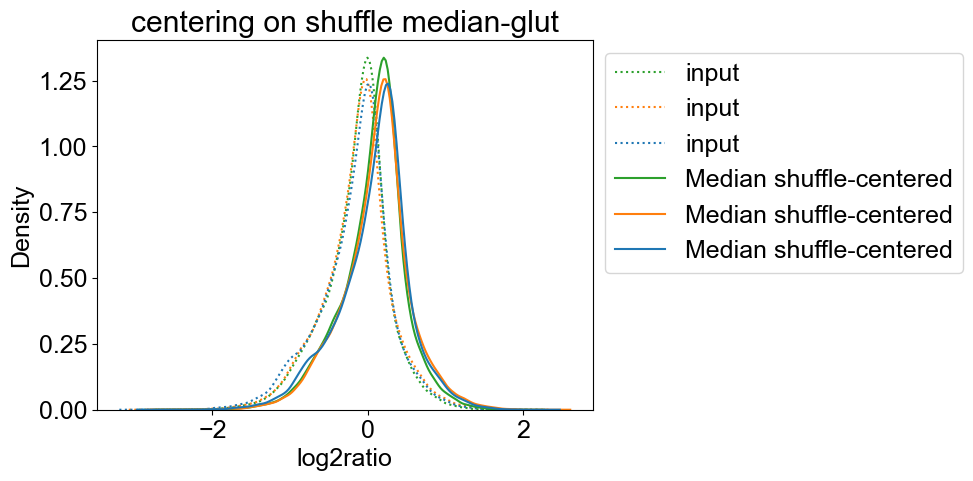



 after centering 

         ctrl sample_id    count       50%       std
0   negative    glut_1    205.0 -0.684462  0.304968
1   negative    glut_2    207.0 -0.580959  0.258853
2   negative    glut_3    205.0 -0.574380  0.298338
3   positive    glut_1    127.0  0.411562  0.207915
4   positive    glut_2    127.0  0.344512  0.202995
5   positive    glut_3    127.0  0.357924  0.242676
6    shuffle    glut_1    179.0  0.000000  0.367824
7    shuffle    glut_2    183.0  0.000000  0.388767
8    shuffle    glut_3    178.0  0.000000  0.401547
9       test    glut_1  35637.0  0.156352  0.465378
10      test    glut_2  35599.0  0.128585  0.424445
11      test    glut_3  35317.0  0.151074  0.449810
z-score
n sequences w/ <3 replicates removed, n= 1141
log2ratio_centered
n sequences w/ <3 replicates removed, n= 1141


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


naming issues: 0
(125074, 22) (110168, 22) removed tags w/ <10 barcodes N= 14906
gaba 

 before centering 

         ctrl sample_id    count       50%       std
0   negative    gaba_1    209.0 -1.518982  0.309172
1   negative    gaba_2    210.0 -1.498370  0.328632
2   negative    gaba_3    209.0 -1.485085  0.296023
3   positive    gaba_1    127.0  0.633998  0.127930
4   positive    gaba_2    127.0  0.640488  0.142543
5   positive    gaba_3    127.0  0.639488  0.137168
6    shuffle    gaba_1    184.0 -0.283298  0.664044
7    shuffle    gaba_2    184.0 -0.310470  0.671824
8    shuffle    gaba_3    183.0 -0.294778  0.669228
9       test    gaba_1  36168.0 -0.065723  0.684488
10      test    gaba_2  36229.0 -0.069030  0.679871
11      test    gaba_3  36211.0 -0.060113  0.681966


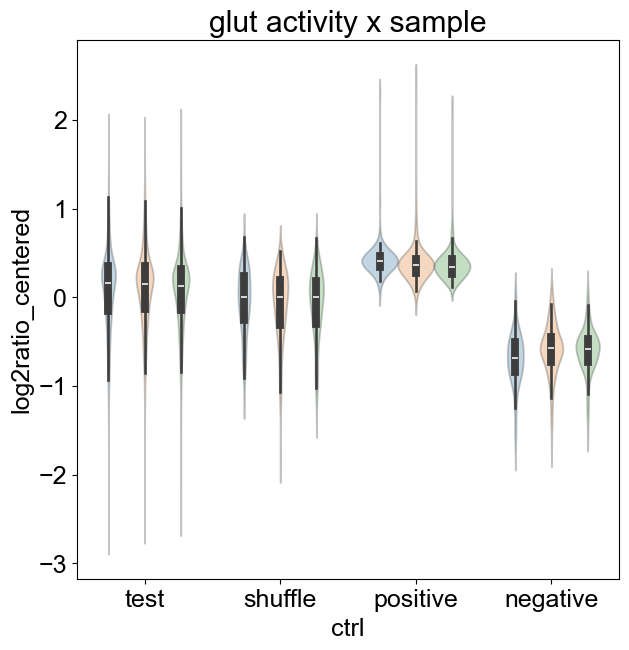

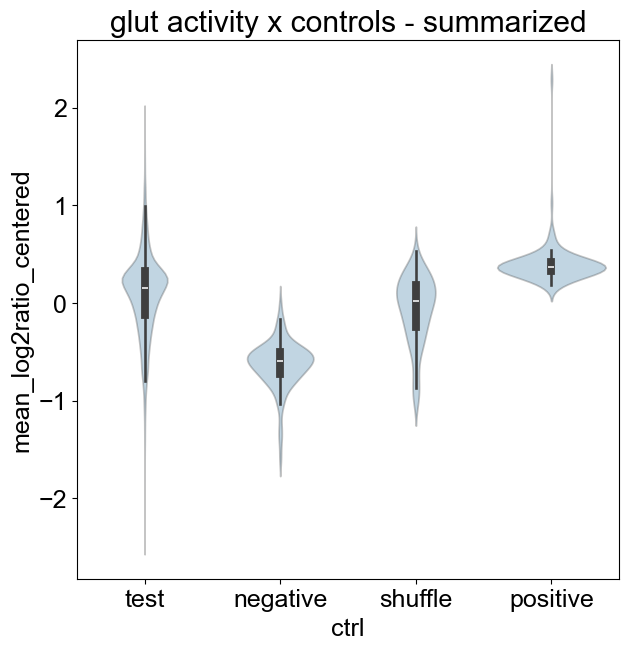

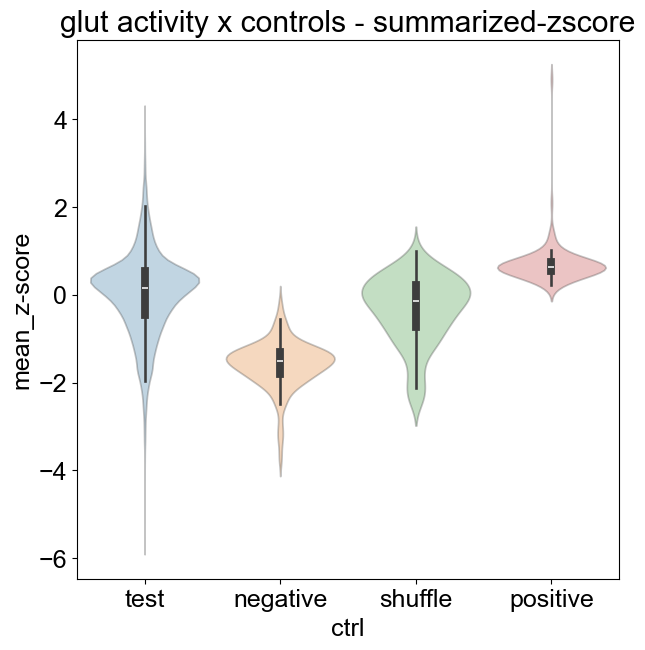

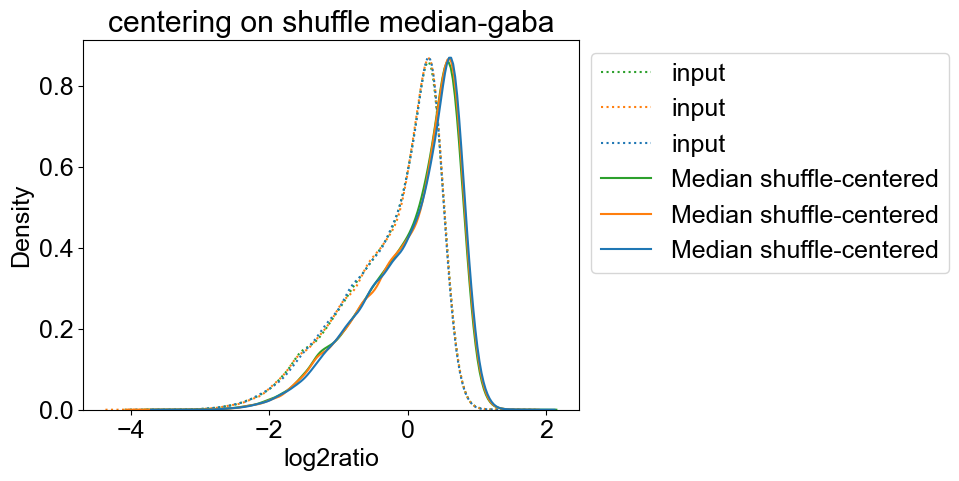



 after centering 

         ctrl sample_id    count           50%       std
0   negative    gaba_1    209.0 -1.235684e+00  0.309172
1   negative    gaba_2    210.0 -1.187900e+00  0.328632
2   negative    gaba_3    209.0 -1.190307e+00  0.296023
3   positive    gaba_1    127.0  9.172962e-01  0.127930
4   positive    gaba_2    127.0  9.509580e-01  0.142543
5   positive    gaba_3    127.0  9.342663e-01  0.137168
6    shuffle    gaba_1    184.0 -2.775558e-17  0.664044
7    shuffle    gaba_2    184.0  0.000000e+00  0.671824
8    shuffle    gaba_3    183.0  0.000000e+00  0.669228
9       test    gaba_1  36168.0  2.175748e-01  0.684488
10      test    gaba_2  36229.0  2.414397e-01  0.679871
11      test    gaba_3  36211.0  2.346652e-01  0.681966
z-score
n sequences w/ <3 replicates removed, n= 643
log2ratio_centered
n sequences w/ <3 replicates removed, n= 643


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


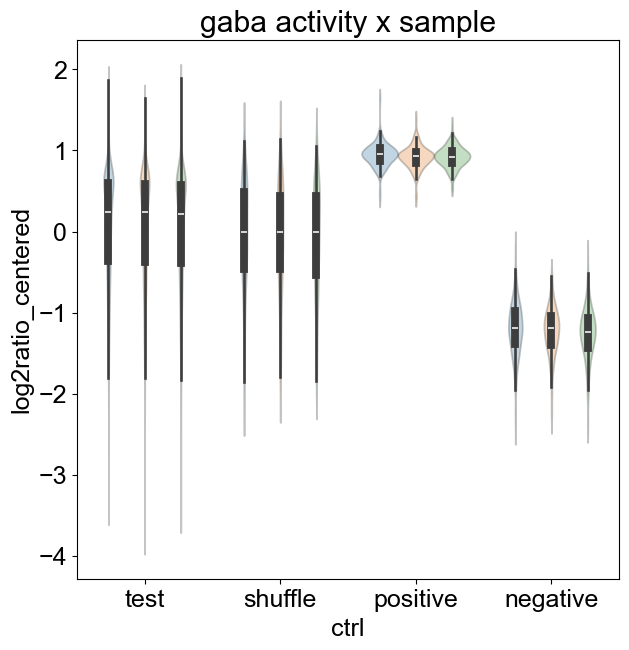

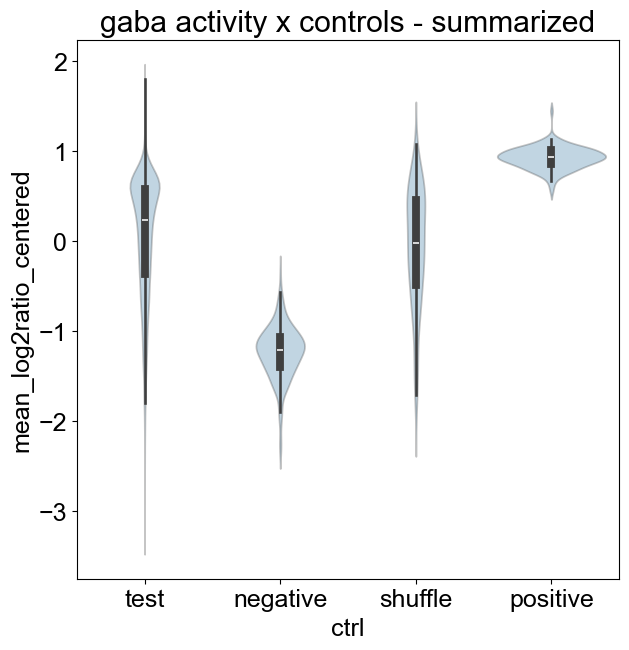

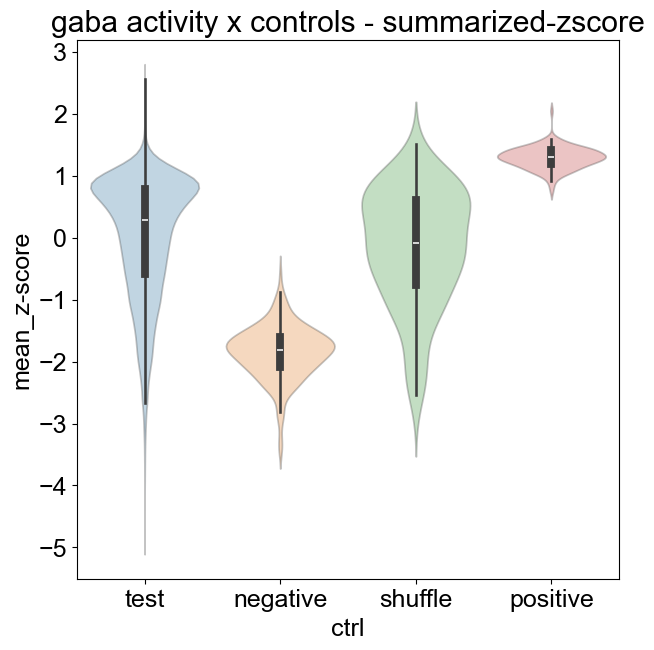

In [10]:
cleaned_reps, summ_act = {}, {}
PLOT = True
for cell_type, files in RUNS.items():
    """
    1. open replicate as pd dataframe
    2. filter out sequences with < 10 barcodes
    3. comput the 
    """

    df = listToDf(files, section)  # make df


    # names w measurements, but do not match meta data

    print("naming issues:", len(set(df["name"]).difference(set(meta["name"]))))

    # add meta data
    df = pd.merge(meta[["name", "#chr", "start", "end"]], df)

    clean_df = removeTags(df, MIN_TAGS)  # clean df for min tags
    clean_df["ctrl"] = clean_df["ctrl"].fillna("test")

    # compute medians per replicate
    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio")

    # summarize activity across replicates before centering
    print(cell_type,
          "\n\n before centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%", "std"]])

    # center values on median of shuffle, or z-score
    clean_df = centerOnShufMed(clean_df, medians)

    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio_centered")  # compute medians

    print("\n\n after centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%", "std"]])  # describe activity across replicates

    # add replicate data to dictionary
    cleaned_reps[cell_type] = clean_df

    ### summarize activity across replicates ###

    sum_df = meanRatio(clean_df)

    # add summarized data to dictionary
    summ_act[cell_type] = sum_df

    if PLOT is True:

        ### plot replicate data ###
        x = "log2ratio_centered"
        data = clean_df
        hue = "ctrl"

        title = f"{cell_type} activity x controls"
        # kdeplot(x, data, hue, title)

        hue = "sample_id"
        title = f"{cell_type} activity x sample"
        # kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "log2ratio_centered"
        hue = "sample_id"
        violinplot(x, y, data, hue, title)

        ### plot summarized data ###
        x = "mean_log2ratio_centered"
        data = sum_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls - summarized"
        # kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "mean_log2ratio_centered"
        hue = None
        violinplot(x, y, data, hue, title)

        x = "ctrl"
        y = "mean_z-score"
        data = sum_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls - summarized-zscore"
        violinplot(x, y, data, hue, title)

## combine replicate glut and gaba data

### clean data

In [11]:
clean_df = pd.concat(cleaned_reps.values()).drop_duplicates()
print(clean_df.shape[0])
clean_df.head()

218259


,name,#chr,start,end,RNA,DNA,ratio,tags,sample_id,celltype,...,coor,top_bottom,strand,enh.id,enh.name,tile.order,log2ratio,log2ratio_shufmedian,log2ratio_centered,z-score
0,chr1:1692002-1692272,chr1,1692002,1692272,0.449739,0.437510,1.027952,46,glut_1,glut,...,chr1:1692002-1692272,NaN,+,chr1:1692002-1692432,enh.46,0.0,0.039773,-0.242330,0.282103,0.440009
1,chr1:1692002-1692272,chr1,1692002,1692272,0.413927,0.423303,0.977850,48,glut_3,glut,...,chr1:1692002-1692272,NaN,+,chr1:1692002-1692432,enh.46,0.0,-0.032315,-0.245015,0.212700,0.285533
2,chr1:1692002-1692272,chr1,1692002,1692272,0.433065,0.460474,0.940477,46,glut_2,glut,...,chr1:1692002-1692272,NaN,+,chr1:1692002-1692432,enh.46,0.0,-0.088536,-0.210841,0.122305,0.084332
3,chr1:1692022-1692292,chr1,1692022,1692292,0.464296,0.498922,0.930598,45,glut_1,glut,...,chr1:1692022-1692292,NaN,+,chr1:1692002-1692432,enh.46,1.0,-0.103769,-0.242330,0.138561,0.120514
4,chr1:1692022-1692292,chr1,1692022,1692292,0.424276,0.498532,0.851050,44,glut_3,glut,...,chr1:1692022-1692292,NaN,+,chr1:1692002-1692432,enh.46,1.0,-0.232683,-0.245015,0.012332,-0.160445


### summarized data

In [12]:
sum_df = pd.concat(summ_act.values()).drop_duplicates()  # concatenate gaba and glut clean reps
print(sum_df.shape)
sum_df.head()

(71799, 7)


,name,coor,strand,ctrl,celltype,mean_z-score,mean_log2ratio_centered
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",chr::-1--1,+,test,glut,-1.696544,-0.677805
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",chr::-1--1,+,test,glut,-1.740263,-0.697447
6,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",chr::-1--1,+,test,glut,-1.842682,-0.743462
9,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",chr::-1--1,+,test,glut,-1.554678,-0.614067
12,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",chr::-1--1,+,test,glut,-2.505154,-1.041096


### keep 6 reps only 
- before, N=37039
- after N=35371

In [28]:
# count how many replicates per oligo
t = clean_df.groupby(["name"])["#chr"].count().reset_index()

# get set of names w/ 6 replicate measures
full_names = set(t.loc[t["#chr"] == 6, "name"])

print("full dataset tiles", len(full_names))

full dataset tiles 35371


In [29]:
t=pd.pivot(sum_df, columns = "celltype", index="name", values="mean_z-score").dropna().reset_index()
t.head()

celltype,name,gaba,glut
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.699699,-1.696544
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.683608,-1.740263
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.228061,-1.842682
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.666574,-1.554678
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.756752,-2.505154


In [31]:
# remove elements wo full datasets
clean_df = clean_df.loc[clean_df['name'].isin(full_names)]
sum_df = sum_df.loc[sum_df['name'].isin(full_names)]

In [34]:
sum_df.loc[sum_df['name'].str.contains("seq"), "name"].unique().shape

(968,)

## barcode count after cleaning

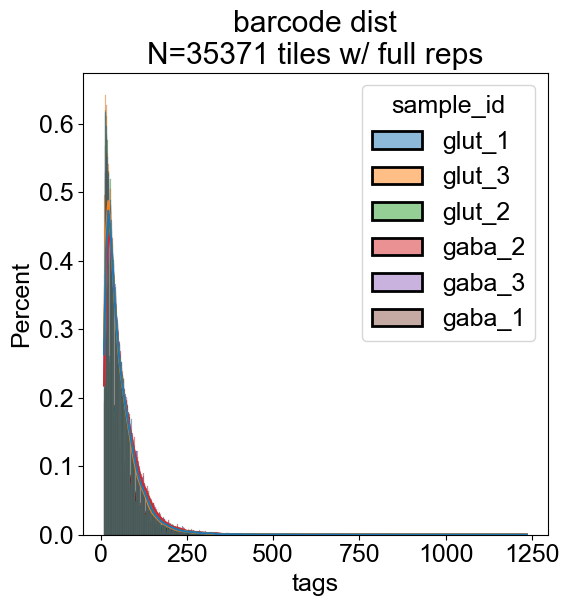

In [33]:
x="tags"
hue="sample_id"
data=clean_df
                  
fig, ax=plt.subplots(figsize=(6,6))
sns.histplot(x=x, data=data, hue=hue, 
             kde=True,
             stat="percent", 
             lw=2,
             alpha=0.5, 
            #clip=(0, 500)
            )
n_tiles = len(full_names)
ax.set(title=f"barcode dist\nN={n_tiles} tiles w/ full reps", 
      #xlim=(-1, 200)
      )
plt.savefig(os.path.join(RE, "barcode.dist.pdf"), bbox_inches="tight")

In [35]:
data.groupby('sample_id')["tags"].describe()

,count,mean,std,min,25%,50%,75%,max
sample_id,,,,,,,,
gaba_1,35371.0,64.914224,59.975792,10.0,27.0,48.0,84.0,1231.0
gaba_2,35371.0,65.679172,60.646311,10.0,27.0,48.0,85.0,1235.0
gaba_3,35371.0,65.682819,60.655424,10.0,27.0,48.0,86.0,1233.0
glut_1,35371.0,61.110995,57.735317,10.0,25.0,45.0,79.0,1219.0
glut_2,35371.0,60.890193,57.620886,10.0,25.0,45.0,79.0,1214.0
glut_3,35371.0,59.217099,56.512868,10.0,24.0,43.0,77.0,1210.0


### N = 35371 elements with 6 replicate measurements 

## Linear regression -  log2ratio_centered ~ tag
- yes, significant, but weak coefficient for number of tags

In [36]:
cols = ["sample_id", "celltype", "tags", "log2ratio_centered"]

# make model array
model=data[cols].drop_duplicates()

model = sm.add_constant(model)
results = smf.ols('log2ratio_centered ~ tags', data=model).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     log2ratio_centered   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3392.
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        13:45:35   Log-Likelihood:            -1.7816e+05
No. Observations:              211016   AIC:                         3.563e+05
Df Residuals:                  211014   BIC:                         3.563e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0029      0.002      1.593      0.1

## evaluate replicate z-score distribution
- shuffled distribution is shifted for GABA, but this should not matter for calling categorical activity, as categorical activity is relative to the 95% of shuffled distribution within that cell type.

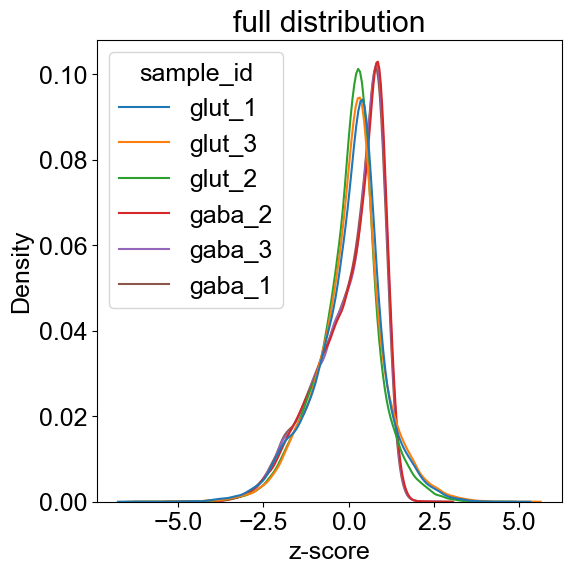

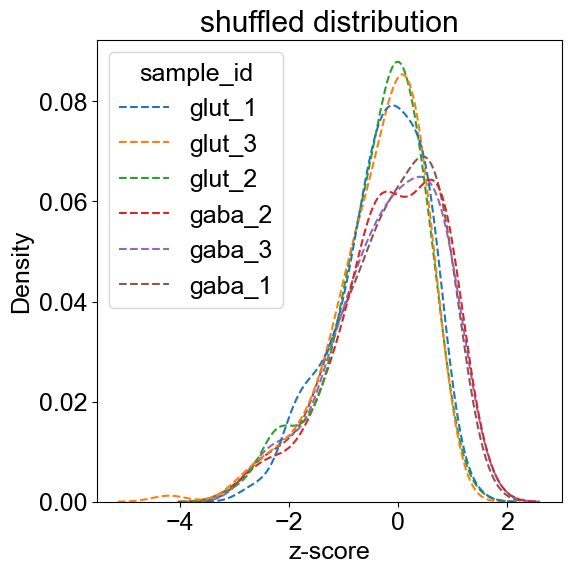

In [37]:
plotting = clean_df[["name", "sample_id", "z-score",
                     "celltype"]].drop_duplicates().copy().reset_index()

# plot z-score dist
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x="z-score", data=plotting, hue='sample_id')
plt.title("full distribution")
plt.savefig(os.path.join(RE, "reps_zscore_full_distribution.pdf"))

# plot shuffled distribution only
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x="z-score",
            data=plotting.loc[plotting["name"].str.contains("shuffle")], hue='sample_id', ls="--")
plt.title("shuffled distribution")
plt.savefig(os.path.join(RE, "reps_zscore_shuffled_distribution.pdf"))

## replicate correlation

### prepare dataframe

In [38]:
# reduce dataframe for computing p-values
cols = ["name", "sample_id", "celltype", "z-score"]
test = clean_df[cols].drop_duplicates()
test.head()

,name,sample_id,celltype,z-score
0,chr1:1692002-1692272,glut_1,glut,0.440009
1,chr1:1692002-1692272,glut_3,glut,0.285533
2,chr1:1692002-1692272,glut_2,glut,0.084332
3,chr1:1692022-1692292,glut_1,glut,0.120514
4,chr1:1692022-1692292,glut_3,glut,-0.160445


### pivot

In [39]:
# pivot table to compute row-wise p-values
rep_table = pd.pivot(test, index="name", columns="sample_id",
                     values="z-score").reset_index()
#rep_table = 
pd.merge(rep_table, meta[["name", "enh.id", "enh.name"]])


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,enh.id,enh.name
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,NaN,NaN
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,NaN,NaN
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,NaN,NaN
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,NaN,NaN
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,NaN,NaN
...,...,...,...,...,...,...,...,...,...
35366,shuffle_94_chr15:32646056-32646326,0.198402,0.324516,0.350354,0.033556,0.145956,-0.093618,chr15:32644836-32646563,enh.537
35367,shuffle_95_chr19:13408968-13409238,0.308939,0.304215,0.184138,-0.046908,-0.135374,-0.533828,chr19:13408398-13409590,enh.766
35368,shuffle_96_chr13:58618367-58618637,0.218985,0.125130,0.256221,-0.005023,-0.203295,0.291430,chr13:58618151-58618757,enh.477
35369,shuffle_98_chr3:12869018-12869288,-0.327067,-0.255239,-0.574992,-0.664113,-0.237368,-0.886876,chr3:12868858-12869288,enh.1176


### plot

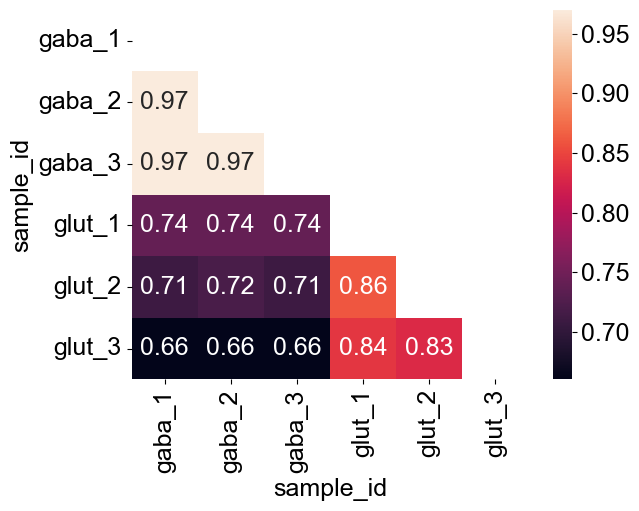

In [40]:
corr=rep_table[rep_table.columns[1:]].corr().round(2)

corr_= corr.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_)

sns.heatmap(corr, annot=True, mask=matrix)
plt.savefig(os.path.join(RE, "rep_corr.pdf"),bbox_inches="tight")

## Wilcoxon's test + significantly different activities between cell types. 
- assumes non-equal variance

### compute pvalue + fdr correction at alpha=0.05

In [41]:
# compute p-value
rep_table = computePval(rep_table, rep_table.columns[1:])

# compute -log10p 
rep_table["-log10p_fdr"] = -1*(np.log10(rep_table["fdr"].astype(float)))

rep_table.to_csv(SIG_ACTIVITY_Z, sep='\t', index=False)
rep_table.head()

sample_id,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,False,0.11939,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,False,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,False,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,False,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,False,0.801537,0.096076


### plot -log10pfdr value histogram

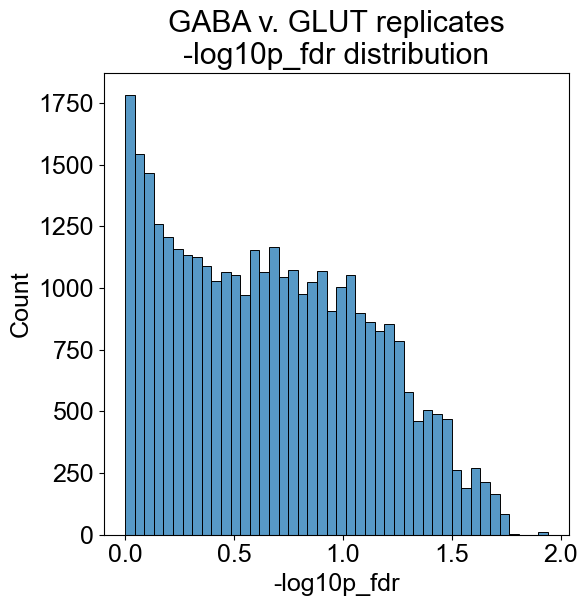

In [43]:
fig, ax= plt.subplots(figsize=(6,6))

sns.histplot(rep_table["-log10p_fdr"])
plt.title("GABA v. GLUT replicates\n-log10p_fdr distribution")
plt.savefig(os.path.join(RE, "pval_dist.pdf"),bbox_inches="tight")

## oligos w significant activity difference between GABA and GLUT N = 3400


In [44]:
rep_table.groupby("fdr_bool")["fdr"].count()

fdr_bool
False    31971
True      3400
Name: fdr, dtype: int64

### sig. synthetics n=23

In [45]:
# how many significant synthetics?
rep_table.loc[(rep_table["name"].str.contains("ground"))
             ].groupby("fdr_bool")["fdr"].count()

fdr_bool
False    945
True      23
Name: fdr, dtype: int64

### sig negative controls N=5

In [46]:
# significant negative
rep_table.loc[(rep_table["name"].str.contains("Negative"))
             ].groupby("fdr_bool")["fdr"].count()

fdr_bool
False    211
True       5
Name: fdr, dtype: int64

### sig positive controls N=44

In [47]:
# positive controls
rep_table.loc[(rep_table["name"].str.contains("Positive"))
             ].groupby("fdr_bool")["fdr"].count()

fdr_bool
False    84
True     44
Name: fdr, dtype: int64

### sig positive controls
- Positive GABA significant oligos n = 12
- Positive GLUT significant oligos n = 16 

In [48]:
print(rep_table.loc[(rep_table["name"].str.contains("Positive-GABA"))&
              (rep_table["fdr_bool"]==True), "name"].shape)
print(rep_table.loc[(rep_table["name"].str.contains("Positive-GLUT"))&
              (rep_table["fdr_bool"]==True), "name"].shape)
rep_table.loc[(rep_table["name"].str.contains("Positive-chr"))&
              (rep_table["fdr_bool"]==True), "name"].shape

(12,)
(16,)


(16,)

## q-q plot is right skewed. 

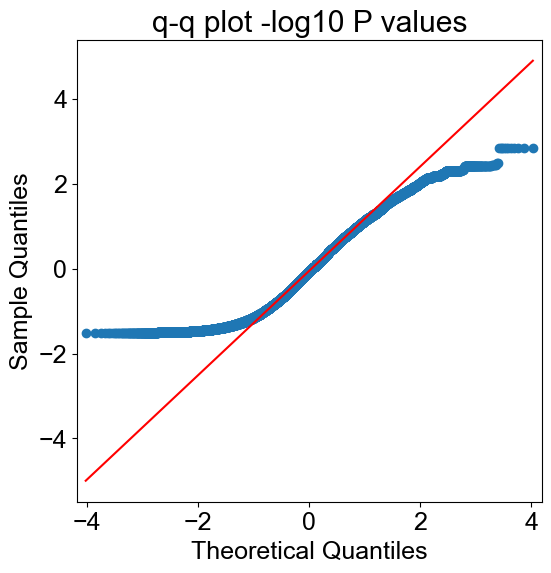

In [49]:
import pylab 

fig, ax= plt.subplots(figsize=(6,6))
measurements = rep_table["-log10p_fdr"]
sm.qqplot(measurements, line='q',ax=ax, fit=True)
ax.set(title="q-q plot -log10 P values")
pylab.show()

# Label active oligos - exceeds shuffled dist 95% PI
- compute labels per cell type

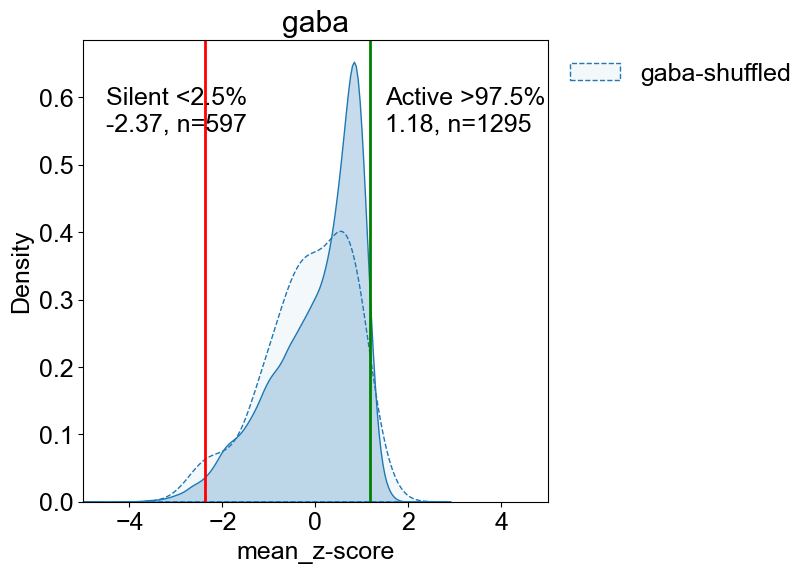

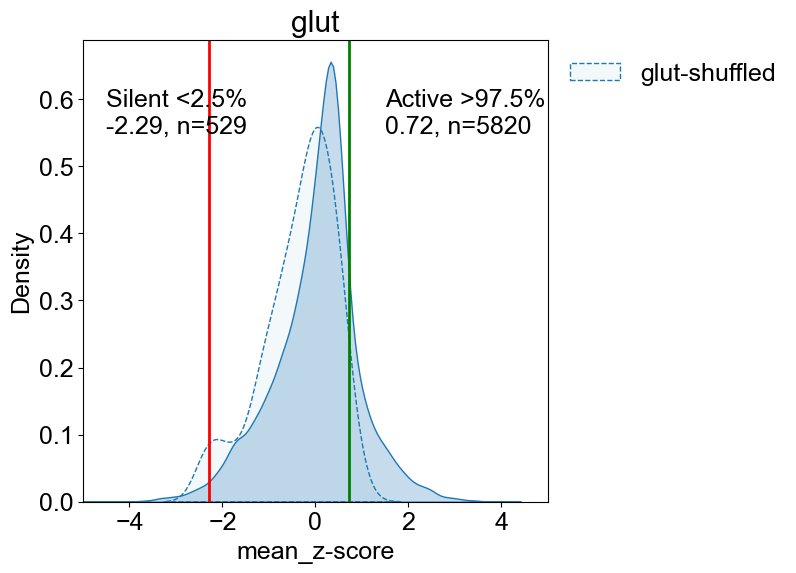

In [50]:
col = "mean_z-score"

test = sum_df.loc[sum_df["ctrl"].str.contains("test")].reset_index()
shufs = sum_df.loc[sum_df["name"].str.contains("shuffle")].reset_index()

celltypes = ["gaba", "glut"]
for cell in celltypes:
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_shuf = shufs.loc[shufs["celltype"] == cell]
    plot_test = test.loc[test["celltype"] == cell]
    #plot_test = plot_test.loc[plot_test["fdr_bool"]==True]

    # get quantiles
    median_ci = shufs.loc[shufs["celltype"]
                          == cell, col].quantile(0.5).round(2)
    high_ci = shufs.loc[shufs["celltype"] ==
                        cell, col].quantile(0.975).round(2)
    low_ci = shufs.loc[shufs["celltype"] == cell, col].quantile(0.025).round(2)
    active = plot_test.loc[plot_test[col] > high_ci].shape[0]
    silent = plot_test.loc[plot_test[col] < low_ci].shape[0]

    # plot shuffled distribution of activity scores
    sns.kdeplot(x=col, data=plot_shuf, label="shuf",
                hue="celltype", fill=True,
                color= "grey", alpha=0.05, ls="--", ax=ax)

    # plot full distribution of activity scores
    sns.kdeplot(x=col, data=plot_test, label="data",
                hue="celltype", ax=ax, fill=True)

    
    #ax.axvline(median_ci, ls="--", )
    ax.axvline(high_ci, color="green", lw=2)
    ax.axvline(low_ci, color="red", lw=2)
    
    ax.text(-4.5, 0.55, f"Silent <2.5%\n{low_ci}, n={silent}")
    #ax.text(-0.5, 0.1, "50%")
    ax.text(1.5, 0.55, f"Active >97.5%\n{high_ci}, n={active}")
    ax.set(xlim=(-5, 5),
           title=cell)
    ax.legend([f"{cell}-shuffled"], bbox_to_anchor=(1, 1), frameon=False)

    plt.savefig(os.path.join(
        RE, f"distribution.meanzscore.{cell}.pdf"), bbox_inches='tight')

check replicates, barcode number, standard scaling

- talk to chengyu and gina

# shuffled-only distributions
## trans differences between glut/gaba shuffled elements 

tags MannwhitneyuResult(statistic=157609.5, pvalue=0.08935900694008723)
log2ratio MannwhitneyuResult(statistic=148169.0, pvalue=0.9081251665745864)
log2ratio_centered MannwhitneyuResult(statistic=157762.0, pvalue=0.08399176262812162)
z-score MannwhitneyuResult(statistic=168675.0, pvalue=0.00013064843747677448)


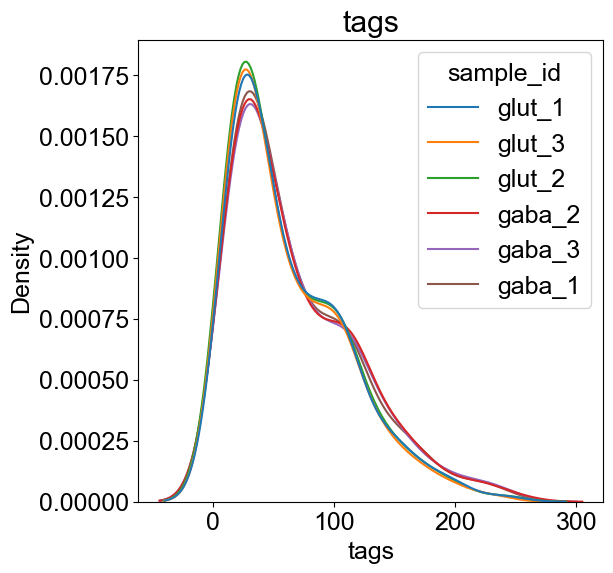

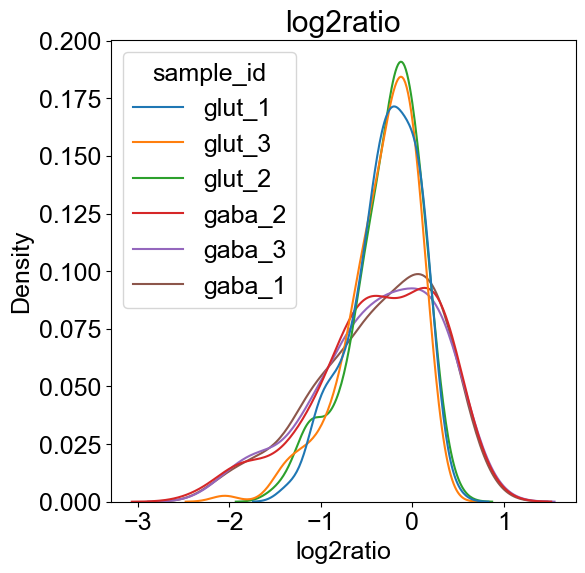

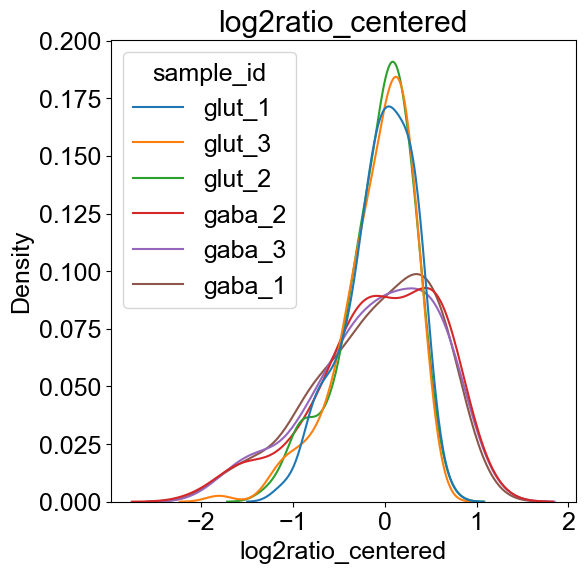

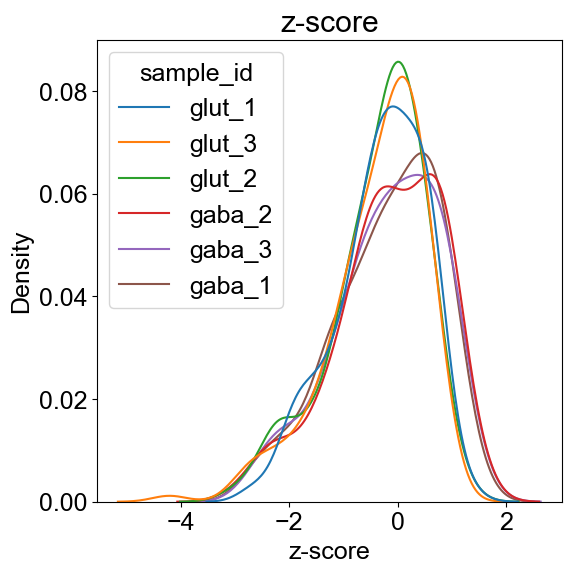

In [51]:
clean_df = pd.concat(cleaned_reps.values()).drop_duplicates()  # concatenate gaba and glut clean reps

cols = ["tags", "log2ratio", "log2ratio_centered", "z-score"]
clean_shuf = clean_df.loc[clean_df["ctrl"] =="shuffle"]
for col in cols:
    gaba_series = list(clean_shuf.loc[clean_shuf['celltype']=="gaba", col])
    glut_series = list(clean_shuf.loc[clean_shuf['celltype']=="glut", col])
    print(col, stats.mannwhitneyu(gaba_series, glut_series ))

    fig, ax= plt.subplots(figsize =(6,6))
    
    sns.kdeplot(x=col, data=clean_shuf, hue="sample_id")
    ax.set(title=col)

# z-score ~ cell type, tags

In [52]:
model = clean_df.copy()
model=model.rename(columns = {"z-score": "z"})
model = sm.add_constant(model)
results = smf.ols('z ~ celltype  + tags', data=model).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2391.
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        13:53:49   Log-Likelihood:            -3.0733e+05
No. Observations:              218259   AIC:                         6.147e+05
Df Residuals:                  218256   BIC:                         6.147e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1583      0.004  

# compare cell type specific activity

 DO STRAND another time

In [53]:
def labelStrand(df_, celltype):
    df = df_.loc[df_["name"].str.contains("chr")]

    print(df.shape)
    
    df = pd.pivot(df, index="coor", columns="strand",
                  values='active').reset_index()
    df[f"n.active.strands.{celltype}"] = df["+"] + df["-"]

    return df

In [54]:
# make joint df
celltypes = {"glut": None, "gaba": None}

for celltype in celltypes.keys():
    print(celltype)

    cell_df = summ_act[celltype]  # get summary dataframe

    # label categorical activity
    cell_df = labelActive(cell_df, dif_col, celltype)

    # add to dictionaries
    # update the dataframe
    celltypes[celltype] = cell_df

glut
mean_z-score shuf top 97.5% = 0.72 shuf bottom 2.5% = -2.29
gaba
mean_z-score shuf top 97.5% = 1.18 shuf bottom 2.5% = -2.36


## df w/ both cell types activity measures

In [55]:
cols = ['name', "celltype", dif_col,"active"]
joint_activity = pd.concat((celltypes["glut"][cols], 
                            celltypes["gaba"][cols])
                         ).drop_duplicates()
joint_activity

,name,celltype,mean_z-score,active
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",glut,-1.696544,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",glut,-1.740263,False
6,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",glut,-1.842682,False
9,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",glut,-1.554678,False
12,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",glut,-2.505154,silencing
...,...,...,...,...
109110,shuffle_95_chr19:13408968-13409238,gaba,0.265764,False
109113,shuffle_96_chr13:58618367-58618637,gaba,0.200112,False
109116,shuffle_97_chr9:32573222-32573492,gaba,-0.362111,False
109119,shuffle_98_chr3:12869018-12869288,gaba,-0.385766,False


# categorical activity differences from 95% PI shuffles
- glut [[activating, silencing, False]] != gaba [[activating, silencing, False]]

            sig 	gaba 	glut 	name
        0 	False 	False 	False 	25741
        1 	False 	False 	activating 	4305
        2 	False 	False 	silencing 	221
        3 	False 	activating 	False 	470
        4 	False 	activating 	activating 	606
        5 	False 	silencing 	False 	323
        6 	False 	silencing 	activating 	1
        7 	False 	silencing 	silencing 	304
        8 	True 	False 	False 	2150
        9 	True 	False 	activating 	861
        10 	True 	False 	silencing 	25
        11 	True 	activating 	False 	248
        12 	True 	activating 	activating 	108
        13 	True 	silencing 	False 	8


In [56]:
joint_activity = pd.merge(joint_activity, 
                          rep_table[["name", "fdr", '-log10p_fdr']])#.drop_duplicates().shape

## make sig col

In [57]:
# label elements with significant activity
joint_activity["sig"] = False
joint_activity.loc[joint_activity["fdr"]<0.05, "sig"] = True

In [58]:
# compare gaba v. glut activity labels by pivoting table
activity = pd.pivot(joint_activity, index="name",
                    columns='celltype', 
                    values=dif_col).reset_index().dropna().drop_duplicates()

activity = pd.merge(activity, joint_activity[['name', "sig"]]).drop_duplicates()

labels = pd.pivot(joint_activity, index="name",
                    columns='celltype', 
                    values='active').reset_index().dropna()

labels = pd.merge(labels, joint_activity[['name', "sig"]]).drop_duplicates()

## significant, cell-type-specific MPRA activtiy counts

In [59]:
sig = labels.sort_values(by='sig', ascending=False).groupby(["sig", "gaba", "glut", ])["name"].count().reset_index()
sig

,sig,gaba,glut,name
0,False,False,False,25741
1,False,False,activating,4305
2,False,False,silencing,221
3,False,activating,False,470
4,False,activating,activating,606
5,False,silencing,False,323
6,False,silencing,activating,1
7,False,silencing,silencing,304
8,True,False,False,2150
9,True,False,activating,861


### plot significant activity differences + categorical activity differences

0 861.0 0.8 -0.4
0 25.0 0.7999999999999999 0.6
0 248.0 0.7999999999999998 1.6
0 108.0 0.7999999999999998 2.6
0 8.0 0.8000000000000003 3.6


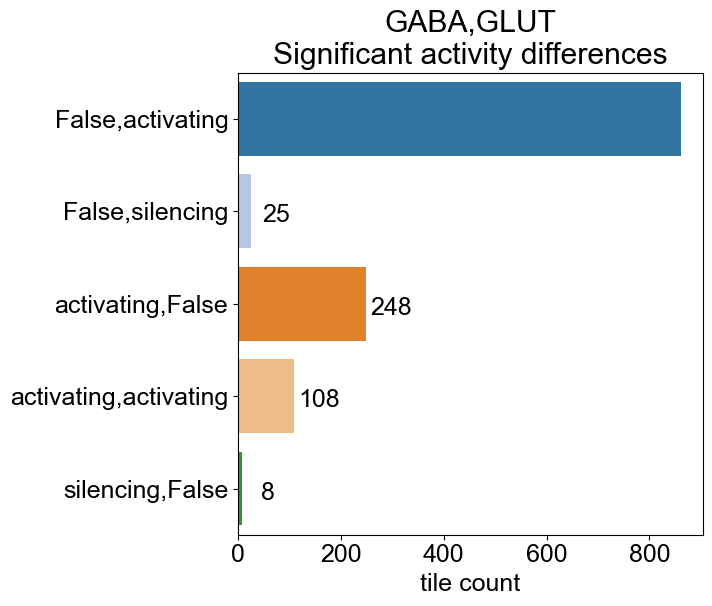

In [60]:
x = 'gaba,glut'
y = "name"
sig[x] = sig["gaba"].map(str) + "," + sig["glut"].map(str)

plot_data = sig.loc[(sig.sig == True)
                    & (sig[x] != "False,False")]

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=y, y=x,
            data=plot_data, 
            palette="tab20"
            )
# show the mean
for p in ax.patches:

    h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
    print(x, w, h, y)
    xy = (w+50, y+0.45)

    ax.annotate(text=int(w), xy=xy, ha='center', va='center')
ax.set(xlabel="tile count", 
       title="GABA,GLUT\nSignificant activity differences", 
      ylabel = "")

plt.savefig(os.path.join(RE, "sig.activitydif.counts.pdf"), bbox_inches="tight")

## label categorical celltype_dif activity
- Note: instances when labels are not the same between GAVA and Glut

In [61]:
# column to label categorical celltype_dif, based on whether GABA|GLUT activity exceeds 
labels['celltype_dif'] = False

labels.loc[labels["gaba"]!=labels["glut"], "celltype_dif"] = True 
labels = labels.rename(columns={"gaba": "gaba-label", "glut": "glut-label"})

dif_activity = labels.groupby(["sig", "celltype_dif"]).count().reset_index()

dif_activity

,sig,celltype_dif,name,gaba-label,glut-label
0,False,False,26651,26651,26651
1,False,True,5320,5320,5320
2,True,False,2258,2258,2258
3,True,True,1142,1142,1142


## count 

In [62]:
# synthetics
labels.loc[labels["name"].str.contains("seq")].groupby("celltype_dif")["name"].count()

celltype_dif
False    835
True     133
Name: name, dtype: int64

In [63]:
# positive glues
labels.loc[labels["name"].str.contains("Positive-GLUT")].groupby("celltype_dif")["name"].count()

celltype_dif
False    16
True     27
Name: name, dtype: int64

In [64]:
# positive gaba
labels.loc[labels["name"].str.contains("Positive-GABA")].groupby("celltype_dif")["name"].count()

celltype_dif
False    21
True     19
Name: name, dtype: int64

In [65]:
# positive genomic
labels.loc[labels["name"].str.contains("Positive-chr")].groupby("celltype_dif")["name"].count()

celltype_dif
False    15
True     29
Name: name, dtype: int64

### how many are statistically significant and categorically differentially active? 

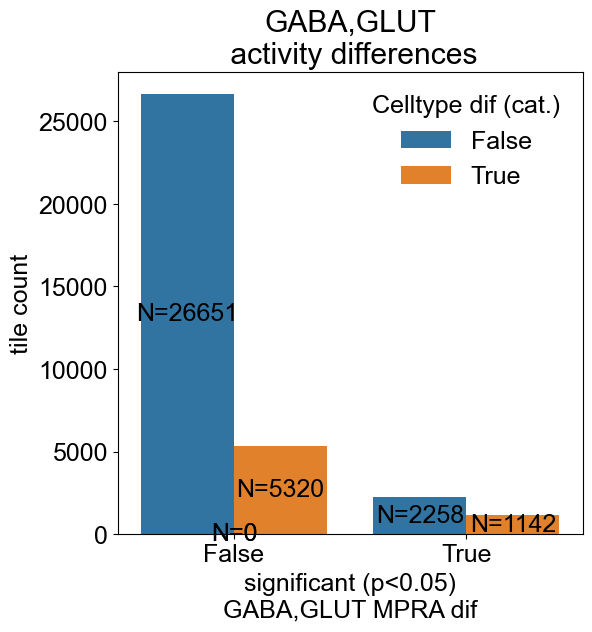

In [66]:
x = "sig"
y="name"
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=x, y=y, data= dif_activity, hue="celltype_dif")

ax.set(ylabel="tile count", 
       title="GABA,GLUT\n activity differences", 
      xlabel = "significant (p<0.05)\nGABA,GLUT MPRA dif")

# show the mean
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'N={int(h)}'
    ax.annotate(text=text, xy=xy, ha='center', va='center')
ax.legend(title="Celltype dif (cat.)", frameon=False)

plt.savefig(os.path.join(RE, "activitydif.counts.pdf"), bbox_inches="tight")

## 3% of tiles have sig AND categorically dif activity

In [67]:
1142/35317

0.03233570235297449

## add differential activity information to the column

In [68]:
activity = pd.merge(activity, labels[["name", 'celltype_dif']], how="left")
activity["delta.gaba-glut"] = activity['gaba'] - activity["glut"]

activity = pd.merge(labels, activity)
activity = pd.merge(activity, rep_table[["name", "fdr", "-log10p_fdr"]]).drop_duplicates()
activity.dropna().shape #35371

(35371, 10)

# bootstrap median confidence intervals of delta activity from full dist. 
- use delta gaba.glut from full data distribution

In [69]:
if "bsdelta.n" not in list(config[section]):

    # set up and bootstrap delta effect sizes
    BS = 1000
    bs_results975, bs_results025 = [], []
    
    for i in np.arange(BS):

        # bootstrap from entire MPRA distribution
        bsdf = activity[["name", "gaba", "glut", "delta.gaba-glut"]
                   ].drop_duplicates().copy()
        
        # sample delta scores with replacement
        sample = bsdf["delta.gaba-glut"].sample(n=bsdf.shape[0], replace=True)

        # bootstrap 95% confidence intervals
        bs_results975.append(sample.quantile(0.975))
        bs_results025.append(sample.quantile(0.025))

    BS975_MED, BS025_MED= np.median(bs_results975), np.median(bs_results025)

    # write results to config
    config[section]["bsdelta.n"]= str(BS)
    config[section]["bs975.delta.1000.median"] = str(BS975_MED)
    config[section]["bs025.delta.1000.median"] = str(BS025_MED)
    crw.write(config, cfn)

else: # pull from config
    BS975_MED =  float(config[section]["bs975.delta.1000.median"])
    BS025_MED =  float(config[section]["bs025.delta.1000.median"])
    BS = int(config[section]["bsdelta.n"])

# print boostrated confidence intervals    
print("bootstrapped median 97.5% and 2.5% ci's",
      BS975_MED, BS025_MED, BS)

bootstrapped median 97.5% and 2.5% ci's 1.160405260558053 -1.6148481368655734 1000


## label tiles exceeding the bs delta.activity confidence intervals

In [71]:
# label elements that exceed the confidence intervals 
activity["bs"] = False
activity["bs"] = activity['delta.gaba-glut'].apply(lambda x: True if x >  BS975_MED or x < BS025_MED else False)
activity.head()

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.11939,0.923032,False
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682,False
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989,False
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076,False


## Write delta activity

In [72]:
activity.to_csv(delta_file, sep='\t', index=False)

# Gaba | glut activating elemetns

## activating in gaba, not active in glut

In [73]:
activity.loc[(activity["gaba-label"]=="activating")&
            (activity['glut-label']!="False")&
            (activity["celltype_dif"]==True)
            &(activity["fdr"]<0.05)].sort_values(by='delta.gaba-glut', ascending=False)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
2883,chr10:97632901-97633171,activating,False,True,True,1.176334,-0.862711,2.039045,0.034528,1.461831,True
7955,chr14:105162488-105162758,activating,False,True,True,1.204357,-0.509433,1.713791,0.017824,1.748995,True
15602,chr1:22710262-22710532,activating,False,True,True,1.394172,-0.155738,1.549909,0.032994,1.481567,True
15007,chr1:16613000-16613270,activating,False,True,True,1.238273,-0.255592,1.493865,0.035507,1.449691,True
11583,chr17:43530352-43530622,activating,False,True,True,1.188100,-0.168260,1.356360,0.024169,1.616734,True
...,...,...,...,...,...,...,...,...,...,...,...
5670,chr12:15363963-15364233,activating,False,True,True,1.198911,0.709941,0.488969,0.029943,1.523710,False
2104,chr10:32055484-32055754,activating,False,True,True,1.190386,0.703461,0.486924,0.038347,1.416269,False
28764,chr5:98510672-98510942,activating,False,True,True,1.176455,0.690502,0.485952,0.034679,1.459938,False
1255,Positive-GLUT_chr2:212699336-212699605:-,activating,False,True,True,1.178294,0.693345,0.484949,0.042029,1.376451,False


## activating in glut, not active in gaba

In [74]:
activity.loc[(activity["gaba-label"]!="False")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==True)&
            (activity["fdr"]<0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
29981,chr6:154127583-154127853,False,activating,True,True,-0.387155,3.235735,-3.622891,0.024016,1.619496,True
18752,chr21:37366535-37366805,False,activating,True,True,0.387940,3.711911,-3.323971,0.036495,1.437769,True
29983,chr6:154127623-154127893,False,activating,True,True,-0.253366,3.044297,-3.297663,0.026763,1.572463,True
29979,chr6:154127543-154127813,False,activating,True,True,-0.608899,2.673463,-3.282361,0.042516,1.371444,True
9710,chr15:48891176-48891446,False,activating,True,True,0.164271,3.439567,-3.275296,0.023226,1.634019,True
...,...,...,...,...,...,...,...,...,...,...,...
25540,chr4:61366602-61366872,False,activating,True,True,1.102169,0.800007,0.302163,0.043833,1.358201,False
23178,chr3:115550970-115551240,False,activating,True,True,1.113588,0.781870,0.331718,0.049802,1.302752,False
3886,chr11:43736890-43737160,False,activating,True,True,1.084276,0.720894,0.363382,0.039002,1.408912,False
21010,chr2:166394071-166394341,False,activating,True,True,1.114449,0.741931,0.372518,0.039359,1.404960,False


## silencing in gaba, activating in glut

In [75]:
activity.loc[(activity["gaba-label"]=="silencing")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==True)&
            (activity["fdr"]<0.05)]

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs


## commonly activating

In [76]:
activity.loc[(activity["gaba-label"]=="activating")&
            (activity['glut-label']=="activating")&
            (activity["celltype_dif"]==False)&
            (activity["fdr"]>0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
4152,chr11:45288365-45288635,activating,activating,False,False,1.228760,3.378958,-2.150197,0.099466,1.002324,True
10103,chr15:92904166-92904436,activating,activating,False,False,1.247518,3.237913,-1.990395,0.072062,1.142292,True
3739,chr11:134902321-134902591,activating,activating,False,False,1.426010,3.358218,-1.932208,0.062279,1.205657,True
13018,chr19:13408868-13409138,activating,activating,False,False,1.202636,3.076179,-1.873543,0.128556,0.890909,True
28117,chr5:35370443-35370713,activating,activating,False,False,1.599622,3.412068,-1.812447,0.090018,1.045669,True
...,...,...,...,...,...,...,...,...,...,...,...
25800,chr4:61490273-61490543,activating,activating,False,False,1.553215,0.809876,0.743338,0.062243,1.205907,False
1199,Positive-GABA_chr12:44257591-44257860:+,activating,activating,False,False,1.532330,0.775367,0.756963,0.062295,1.205545,False
14075,chr19:56508141-56508411,activating,activating,False,False,1.497511,0.734837,0.762674,0.146858,0.833104,False
6851,chr12:8692713-8692983,activating,activating,False,False,1.495133,0.732100,0.763034,0.104145,0.982360,False


## commonly silencing

In [77]:
activity.loc[(activity["gaba-label"]=="silencing")&
            (activity['glut-label']=="silencing")&
            (activity["celltype_dif"]==False)&
            (activity["fdr"]>0.05)].sort_values(by='delta.gaba-glut', ascending=True)

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
18542,chr21:25734941-25735211,silencing,silencing,False,False,-3.777996,-2.574176,-1.203820,0.110287,0.957476,False
12023,chr17:50719774-50720044,silencing,silencing,False,False,-3.563342,-2.521192,-1.042150,0.515484,0.287785,False
19488,chr22:24134195-24134465,silencing,silencing,False,False,-3.525382,-2.610592,-0.914791,0.508205,0.293961,False
21111,chr2:169479498-169479768,silencing,silencing,False,False,-3.216561,-2.368720,-0.847841,0.330515,0.480808,False
9654,chr15:43746538-43746808,silencing,silencing,False,False,-3.582571,-2.748400,-0.834172,0.419237,0.377540,False
...,...,...,...,...,...,...,...,...,...,...,...
29373,chr6:101799678-101799948,silencing,silencing,False,False,-2.915797,-3.800735,0.884938,0.241696,0.616731,False
11011,chr17:10697054-10697324,silencing,silencing,False,False,-2.565590,-3.504729,0.939139,0.091299,1.039532,False
12024,chr17:50719776-50720046,silencing,silencing,False,False,-3.814399,-4.808767,0.994368,0.100621,0.997310,False
22124,chr2:241217661-241217931,silencing,silencing,False,False,-2.471999,-3.789443,1.317445,0.211037,0.675642,True


# full distribution - delta gaba-glut

<Axes: xlabel='delta.gaba-glut', ylabel='Count'>

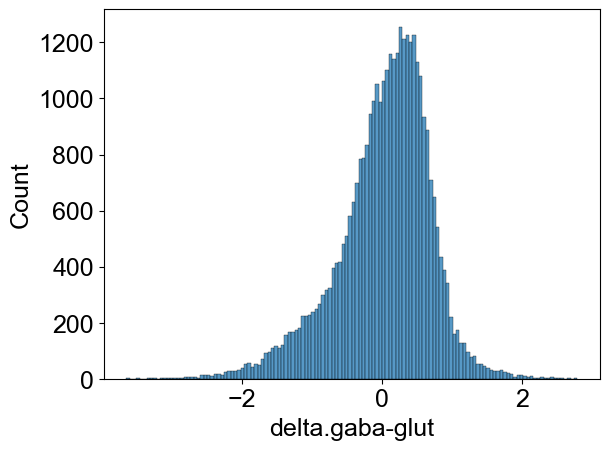

In [78]:
sns.histplot(activity["delta.gaba-glut"])

## joint plot - glut v. gaba

[Text(0.5, 1.0, 'MPRA activity\nmean_z-score'), (-6.0, 6.0), (-6.0, 6.0)]

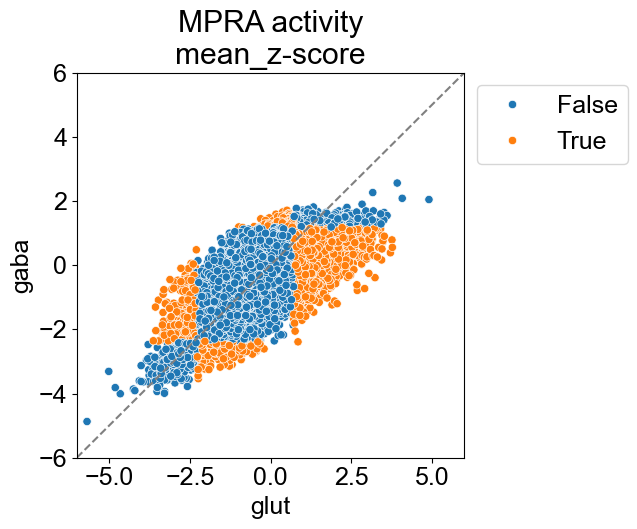

In [79]:
x = 'glut'
y = 'gaba'
hue ="celltype_dif"
data = activity
size = (-6,6)

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=x, y=y, data=data,hue=hue)
plt.plot(size,size, ls = "--", color="grey")
ax.legend(bbox_to_anchor=(1,1))
ax.set(title=f"MPRA activity\n{dif_col}",
      ylim=size,xlim=size)

# pearson correlation between cell types

### all data - Gaba v. Glut

In [80]:
stats.pearsonr(data[x], data[y])

PearsonRResult(statistic=0.7513628420225749, pvalue=0.0)

### shuffles only

In [81]:
vals = ["shuf", "Positive", "Negative", "72"]
for val in vals:

    subset = data.loc[data["name"].str.contains(val)]
    print(val, stats.pearsonr(subset[x], subset[y]))

shuf PearsonRResult(statistic=0.8628272072365779, pvalue=9.864770679376597e-54)
Positive PearsonRResult(statistic=0.3913174150487022, pvalue=4.94020910752841e-06)
Negative PearsonRResult(statistic=0.7730691867577508, pvalue=3.4746681277355833e-44)
72 PearsonRResult(statistic=0.7756924344510415, pvalue=0.0)


## how many celltype-specific active?

 2x2 celltype specific coors enriched for strand-specific effects?
 
     - a = n coordinates with cell type AND strand-specific
     - b = n coordinates with cell type NOT strand-specific
     - c = n coordinates NOT cell type specific AND strand-specific
     - d = n coordinates NOT cell type NOT strand-specific
     
        ss +     ss-
    cs +   A.       B
    cs -   C.       D

## Do FET